In [1]:
import sys

In [2]:
sys.path.insert(0, "/home/shashank/Desktop/todynet/dtw_tsl_stuff/txai_old")

In [3]:
# import tint

In [4]:
from matplotlib import rcParams
from matplotlib import font_manager as fm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns

In [5]:
# Manually specify the font path
font_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"  # Update if necessary
times_new_roman = fm.FontProperties(fname=font_path)

# Set the font globally
rcParams['font.family'] = times_new_roman.get_name()

In [6]:
from tint.attr import DynaMask, ExtremalMask

## load model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, matthews_corrcoef, roc_auc_score, precision_recall_curve, auc

import os
import random
import gc

In [8]:
# from einops import rearrange, repeat
# import math


# class DSW_embedding(nn.Module):
#     def __init__(self, seg_len, d_model):
#         super(DSW_embedding, self).__init__()
#         self.seg_len = seg_len
#         self.d_model = d_model
#         self.linear = nn.Linear(seg_len * 231, d_model)

#     def forward(self, x):
#         batch, ts_len, ts_dim = x.shape
#         pad_len = (self.seg_len - (ts_len % self.seg_len)) % self.seg_len
#         if pad_len != 0:
#             x = torch.cat([x, torch.zeros(batch, pad_len, ts_dim).to(x.device)], dim=1)
#         seg_num = (ts_len + pad_len) // self.seg_len
#         x_segment = rearrange(x, 'b (seg_num seg_len) d -> b seg_num (seg_len d)', seg_len=self.seg_len)
#         x_embed = self.linear(x_segment)
#         # Reshape to (batch, seg_num * seg_len, d_model)
#         x_embed = x_embed.unsqueeze(2).repeat(1, 1, self.seg_len, 1)
#         x_embed = x_embed.view(batch, -1, self.d_model)
#         return x_embed[:, :ts_len, :]  # Remove the padding

# class SegMerging(nn.Module):
#     def __init__(self, d_model, win_size, norm_layer=nn.LayerNorm):
#         super().__init__()
#         self.d_model = d_model
#         self.win_size = win_size
#         self.linear_trans = nn.Linear(d_model, d_model)
#         self.norm = norm_layer(d_model)

#     def forward(self, x):
#         x = self.norm(x)
#         x = self.linear_trans(x)
#         return x

# class AttentionLayer(nn.Module):
#     def __init__(self, d_model, n_heads, dropout=0.1):
#         super(AttentionLayer, self).__init__()
#         self.n_heads = n_heads
#         self.d_model = d_model
#         self.d_k = d_model // n_heads

#         self.qkv_proj = nn.Linear(d_model, 3 * d_model)
#         self.o_proj = nn.Linear(d_model, d_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, q, k, v):
#         B, L, _ = q.size()
#         qkv = self.qkv_proj(q).chunk(3, dim=-1)
#         q, k, v = [rearrange(x, 'b l (h d) -> b h l d', h=self.n_heads) for x in qkv]

#         scores = torch.einsum('bhld,bhmd->bhlm', q, k) / math.sqrt(self.d_k)
#         attn = scores.softmax(dim=-1)
#         attn = self.dropout(attn)

#         context = torch.einsum('bhlm,bhmd->bhld', attn, v)
#         context = rearrange(context, 'b h l d -> b l (h d)')
#         output = self.o_proj(context)
#         return output

# class CrossEncoder(nn.Module):
#     def __init__(self, d_model, n_heads, d_ff, block_depth, dropout, factor, e_blocks, win_size):
#         super().__init__()
#         self.time_attention = AttentionLayer(d_model, n_heads, dropout)
#         self.dim_sender = AttentionLayer(d_model, n_heads, dropout)
#         self.dim_receiver = AttentionLayer(d_model, n_heads, dropout)
#         self.router = nn.Parameter(torch.randn(e_blocks, factor, d_model))
        
#         self.dropout = nn.Dropout(dropout)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.norm3 = nn.LayerNorm(d_model)
#         self.norm4 = nn.LayerNorm(d_model)
        
#         self.MLP1 = nn.Sequential(nn.Linear(d_model, d_ff),
#                                   nn.GELU(),
#                                   nn.Linear(d_ff, d_model))
#         self.MLP2 = nn.Sequential(nn.Linear(d_model, d_ff),
#                                   nn.GELU(),
#                                   nn.Linear(d_ff, d_model))

#     def forward(self, x):
#         batch, seq_len, d_model = x.shape
#         time_enc = self.time_attention(x, x, x)
#         dim_in = x + self.dropout(time_enc)
#         dim_in = self.norm1(dim_in)
#         dim_in = dim_in + self.dropout(self.MLP1(dim_in))
#         dim_in = self.norm2(dim_in)

#         dim_send = dim_in
#         batch_router = repeat(self.router, 'e_blocks factor d_model -> (repeat e_blocks) factor d_model', repeat=batch)
#         dim_buffer = self.dim_sender(batch_router, dim_send, dim_send)
#         dim_receive = self.dim_receiver(dim_send, dim_buffer, dim_buffer)
#         dim_enc = dim_send + self.dropout(dim_receive)
#         dim_enc = self.norm3(dim_enc)
#         dim_enc = dim_enc + self.dropout(self.MLP2(dim_enc))
#         dim_enc = self.norm4(dim_enc)

#         return dim_enc

# class EncoderOnlyCrossFormer(nn.Module):
#     def __init__(self, seg_len, d_model, num_classes, num_layers, win_size, n_heads, d_ff, e_blocks, dropout=0.1):
#         super(EncoderOnlyCrossFormer, self).__init__()
        
#         # Embedding layer
#         self.embedding = DSW_embedding(seg_len, d_model)
        
#         # Encoder layers
#         self.encoders = nn.ModuleList([
#             CrossEncoder(d_model=d_model, n_heads=n_heads, d_ff=d_ff, block_depth=1, dropout=dropout, factor=5, e_blocks=e_blocks, win_size=win_size) for _ in range(num_layers)
#         ])
        
#         # Segment merging layer
#         self.seg_merge = SegMerging(d_model, win_size)
        
#         # Classification head
#         self.logit = nn.Linear(d_model, num_classes)
#         self.classifier = nn.Sequential(
#             nn.LayerNorm(d_model),
#             self.logit
#         )
        
#     def forward(self, x):
#         # Apply embedding
#         x_embed = self.embedding(x)
        
#         # Pass through each encoder layer
#         for encoder in self.encoders:
#             x_embed = encoder(x_embed)
        
#         # Merge segments
#         x_merged = self.seg_merge(x_embed)
        
#         # Classification head
#         logits = self.classifier(x_merged)
        
#         return logits

## causal crossformer

In [9]:
from einops import rearrange, repeat
import math


class DSW_embedding(nn.Module):
    def __init__(self, seg_len, d_model):
        super(DSW_embedding, self).__init__()
        self.seg_len = seg_len
        self.d_model = d_model
        self.linear = nn.Linear(seg_len * 231, d_model)

    def forward(self, x):
        batch, ts_len, ts_dim = x.shape
        pad_len = (self.seg_len - (ts_len % self.seg_len)) % self.seg_len
        if pad_len != 0:
            x = torch.cat([x, torch.zeros(batch, pad_len, ts_dim).to(x.device)], dim=1)
        seg_num = (ts_len + pad_len) // self.seg_len
        x_segment = rearrange(x, 'b (seg_num seg_len) d -> b seg_num (seg_len d)', seg_len=self.seg_len)
        x_embed = self.linear(x_segment)
        x_embed = x_embed.unsqueeze(2).repeat(1, 1, self.seg_len, 1)
        x_embed = x_embed.view(batch, -1, self.d_model)
        return x_embed[:, :ts_len, :]


class SegMerging(nn.Module):
    def __init__(self, d_model, win_size, norm_layer=nn.LayerNorm):
        super().__init__()
        self.d_model = d_model
        self.win_size = win_size
        self.linear_trans = nn.Linear(d_model, d_model)
        self.norm = norm_layer(d_model)

    def forward(self, x):
        
        x = self.norm(x)
        x = self.linear_trans(x)
        return x

class AttentionLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_model // n_heads

        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        self.o_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v):
        B, Lq, _ = q.size()
        _, Lk, _ = k.size()

        qkv = self.qkv_proj(q).chunk(3, dim=-1)
        q, k, v = [rearrange(x, 'b l (h d) -> b h l d', h=self.n_heads) for x in qkv]

        scores = torch.einsum('bhqd,bhkd->bhqk', q, k) / math.sqrt(self.d_k)

        if Lq == Lk:
            causal_mask = torch.tril(torch.ones(Lq, Lk, device=q.device)).unsqueeze(0).unsqueeze(0)
            scores = scores.masked_fill(causal_mask == 0, float('-inf'))

        attn = self.dropout(scores.softmax(dim=-1))

        context = torch.einsum('bhqk,bhkd->bhqd', attn, v)
        context = rearrange(context, 'b h l d -> b l (h d)')
        return self.o_proj(context)

class CrossEncoder(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout, factor, e_blocks):
        super().__init__()
        self.time_attention = AttentionLayer(d_model, n_heads, dropout)
        self.dim_sender = AttentionLayer(d_model, n_heads, dropout)
        self.dim_receiver = AttentionLayer(d_model, n_heads, dropout)

        self.router = nn.Parameter(torch.randn(e_blocks, factor, d_model))

        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)

        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_ff), nn.GELU(), nn.Linear(d_ff, d_model))
        self.MLP2 = nn.Sequential(nn.Linear(d_model, d_ff), nn.GELU(), nn.Linear(d_ff, d_model))

    def forward(self, x):
        time_enc = self.time_attention(x, x, x)
        x = x + self.dropout(time_enc)
        x = self.norm1(x)
        x = x + self.dropout(self.MLP1(x))
        x = self.norm2(x)

        batch_router = repeat(self.router, 'e_blocks factor d_model -> (repeat e_blocks) factor d_model', repeat=x.size(0))

        dim_buffer = self.dim_sender(batch_router, x, x)
        dim_receive = self.dim_receiver(x, dim_buffer, dim_buffer)

        x = x + self.dropout(dim_receive)
        x = self.norm3(x)
        x = x + self.dropout(self.MLP2(x))
        x = self.norm4(x)

        return x

class EncoderOnlyCrossFormer(nn.Module):
    def __init__(self, seg_len, d_model, num_classes, num_layers, n_heads, d_ff, e_blocks, dropout=0.1, win_size=1):
        super().__init__()
        self.embedding = DSW_embedding(seg_len, d_model)
        
        self.encoders = nn.ModuleList([
            CrossEncoder(d_model, n_heads, d_ff, dropout, factor=5, e_blocks=e_blocks)
            for _ in range(num_layers)
        ])
        
        # Include the segment merging layer
        self.seg_merge = SegMerging(d_model, win_size)
        
        # Classification head structure as in the original model
        self.logit = nn.Linear(d_model, num_classes)
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            self.logit
        )

    def forward(self, x):
        x_embed = self.embedding(x)

        for encoder in self.encoders:
            x_embed = encoder(x_embed)

        # segment merging (required for compatibility)
        x_merged = self.seg_merge(x_embed)

        logits = self.classifier(x_merged)
        return logits


In [10]:
import warnings

# Suppress warnings from PyTorch
warnings.filterwarnings("ignore", category=UserWarning)
torch.set_printoptions(profile="default")  # Prevent any potential printing-related warnings
import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Suppress Python warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
model_type = 'Causal_Crossformer'

In [12]:
batch_size=1
model_1 = EncoderOnlyCrossFormer(seg_len=1, d_model=36, num_classes=2, num_layers=1, win_size=1, n_heads=2, d_ff=16, e_blocks=1)

In [13]:
# model_path_1 = 'circ_crossformer/testing_Crossformer_Circ_seed_0/model_epoch_40.pth' #model 1
model_path_1 = 'circ_crossformer/circ_best_model/model-causal-circ/model-causal.torch' ## causal model

In [14]:
temp_model = torch.load(model_path_1)
# Extract the model state dictionary
model_state_dict = temp_model['model']

In [15]:
# Load the state dictionary into the model
model_1.load_state_dict(model_state_dict)

<All keys matched successfully>

In [16]:
model1 = model_1.cuda()

In [17]:
total_params = sum(p.numel() for p in model_1.parameters())
print(total_params)

28762


## load data

In [67]:
# temp = np.load('circ_crossformer/circ_data_tensors/data_1605_best.npy')
temp = np.load('circ_crossformer/circ_data_tensors/data_3737_best.npy')

In [68]:
tmp0 = torch.tensor(temp)

In [69]:
tmp0.shape

torch.Size([1, 2016, 231])

In [70]:
exp = DynaMask(model_1)

In [71]:
attr = exp.attribute(tmp0)

Training: |                                                                                                   …

Predicting: |                                                                                                 …

In [72]:
attr

tensor([[[0.0000, 1.0000, 1.0000,  ..., 0.0944, 0.6214, 0.5000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0374, 0.7039, 0.5000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0059, 0.9186, 0.5000],
         ...,
         [0.7392, 0.5138, 0.8183,  ..., 0.3912, 0.7333, 0.5000],
         [0.7299, 0.4125, 0.7874,  ..., 0.5940, 0.7303, 0.5000],
         [0.7616, 0.8210, 0.8296,  ..., 0.8271, 0.7416, 0.5000]]])

In [64]:
attr.shape

torch.Size([1, 2016, 231])

In [73]:
attr_np = attr.detach().cpu().numpy()

In [74]:
# torch.save(attr, 'attr_dynamask_causal_crossformer.pt')
# np.save('attr_dynamask_causal_crossformer_pid1605.npy',attr_np)
# np.save('attr_dynamask_causal_crossformer_pid3737.npy',attr_np)

In [75]:
import matplotlib.pyplot as plt

In [76]:
import cmcrameri.cm as cmc

In [77]:
data0_np = tmp0.numpy().squeeze()

In [78]:
# Calculate row-wise min and max
row_min = data0_np.min(axis=0, keepdims=True)
row_max = data0_np.max(axis=0, keepdims=True)

col_range = (row_max - row_min)

col_range[col_range == 0] = 1  # Set range to 1 for constant columns to avoid division by zero


# Normalize each row to 0-1
data0_np_rownorm = (data0_np - row_min) / col_range

In [80]:
## load labels
label_path   = "circ_crossformer/circ_data_tensors/Circ_test_label.pt"
label_tensor = torch.load(label_path)  # This loads the tensor into CPU memory
# index=1605
index=3737
label0_np= label_tensor[index:index+1].numpy().squeeze()

In [81]:
label0_np_flat = label0_np.reshape(-1,1)
labels_binary = np.where(label0_np_flat == -1, 0, label0_np_flat)
shift_steps = 144  # (12 * 60) / 5

In [82]:
labels_shifted = np.zeros_like(labels_binary)

# Perform the forward shift
labels_shifted[shift_steps:] = labels_binary[:-shift_steps]

In [83]:
labels_shifted_flat = labels_shifted.flatten()

In [84]:
# Find the indices where 1s start and end
starts = np.where(np.diff(np.concatenate(([0], labels_shifted_flat))) == 1)[0]  # Start of chunks
ends = np.where(np.diff(np.concatenate((labels_shifted_flat, [0]))) == -1)[0]  # End of chunks

## VAriance filter

In [85]:
# Remove flat features (features with zero variance)
# non_flat_features = np.var(data0_np_rownorm, axis=0) > 0.05  # Compute variance along the time axis

variances = np.var(data0_np_rownorm, axis=0)

# Dynamic threshold based on the 10th percentile
var_thr = np.percentile(variances, 90)

non_flat_features = np.var(data0_np_rownorm, axis=0) > var_thr  # Compute variance along the time axis


data0_np_rownorm_filter = data0_np_rownorm[:, non_flat_features.squeeze()]  # Filter non-flat features

In [86]:
data0_np_rownorm_filter.shape

(2016, 22)

In [87]:
xticks = np.concatenate((starts, ends))
xtick_labels = [str(x) for x in xticks]

In [88]:
# Define the colormap using matplotlib's ListedColormap
custom_cmap = ListedColormap(['#b5b5b5', '#000000']) 

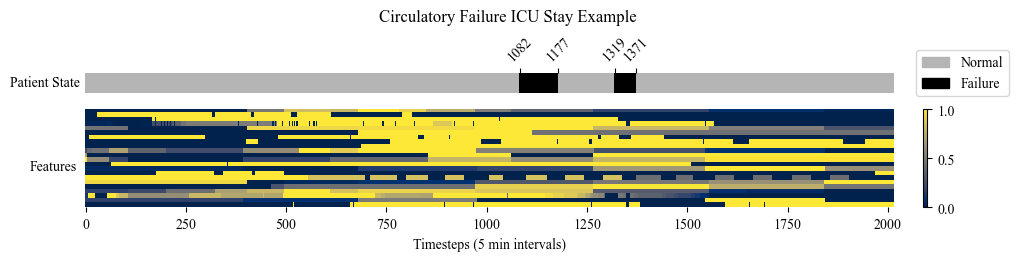

In [90]:
# Create the plot with subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 2.5), gridspec_kw={'height_ratios': [0.2,1]}, 
                       sharex=False,
                        layout='constrained'
                      )  # 1 row, 2 columns for subplots

# Subplot 1: Original heatmap
# im0 = ax[0].imshow(labels_shifted.T, cmap='binary', aspect='auto', interpolation='none')
im0 = ax[0].imshow(labels_shifted.T, cmap=custom_cmap, aspect='auto', interpolation='none')
color_map = {0: '#b5b5b5', 1: '#000000'}
colors = np.vectorize(color_map.get)(labels_shifted)
# Bar plot adjusted to match the width of the plot below
legend_labels = {0: "Normal", 1: "Failure"}
legend_handles = [Patch(color=color, label=legend_labels[label]) for label, color in color_map.items()]
# ax[0].set_title("Circulatory Failure Example")
# ax[0].set_xlabel("Timesteps (5 min intervals)")
ax[0].set_ylabel("Patient State", rotation=0, 
                 # labelpad=30
                )
ax[0].yaxis.set_label_coords(-0.05, 0.15)  # Adjust x and y positions
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_yticks([])  # Remove y-axis labels
# ax[0].axis('off')
ax[0].legend(handles=legend_handles, loc='right', title="",
              # bbox_to_anchor=(1.15, 0.75),
              bbox_to_anchor=(1.15, 1.0),
              # ncol=len(legend_handles),
              ncol=1,             
              # fontsize=12,
              frameon=True,
             )
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xtick_labels, fontsize=10,rotation=45)  # Increase font size
ax[0].tick_params(axis='x', labeltop=True, labelbottom=False, top=True, bottom=False) 


# im1 = ax[1].imshow(data0_np_rownorm_filter.T, cmap='cividis', aspect='auto', interpolation='none')
im1 = ax[1].imshow(data0_np_rownorm_filter.T, cmap='cividis', aspect='auto', interpolation='none')
fig.colorbar(im1, ax=ax[1], 
             location = 'right',
             orientation='vertical',
             fraction=0.9,
             # aspect=2,
             pad=-0.1,
             # bbox_to_anchor=(0.1,0,1,1),
             # shrink=0.5,
             # anchor=(0, 0.5)
            )
# ax[1].set_title("Dataset")
ax[1].set_xlabel("Timesteps (5 min intervals)")
ax[1].set_ylabel("Features", rotation=0, 
                 # labelpad=25
                )
ax[1].yaxis.set_label_coords(-0.04, 0.35)  # Adjust x and y positions
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_yticks([])  # Remove y-axis labels
# Add space between the subplots
# plt.subplots_adjust(hspace=0.5)  # Adjust spacing between subplots

# Add a title to the entire figure
fig.suptitle("Circulatory Failure ICU Stay Example")
# fig.get_layout_engine().set(hspace=0.0, wspace=0)
# Show the plot
# plt.title("Circulatory Failure Example")
# plt.tight_layout(h_pad=1)
plt.show()

In [91]:
# Convert the tensor to a NumPy array
attr_np = attr.numpy().squeeze()

In [92]:
attr_np.shape

(2016, 231)

In [93]:
attr_np_filtered = attr_np[:, non_flat_features.squeeze()]

In [94]:
attr_np_filtered.shape

(2016, 22)

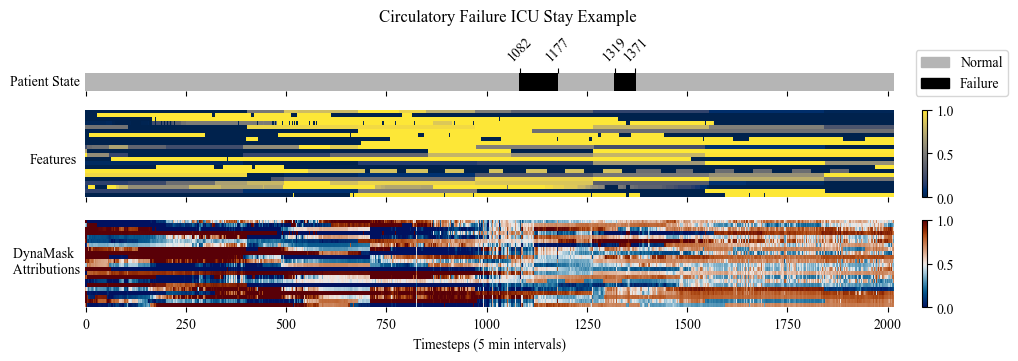

In [96]:
# Create the plot with subplots
fig, ax = plt.subplots(3, 1, figsize=(10, 3.5), gridspec_kw={'height_ratios': [0.2,1,1]}, 
                       sharex=True,
                        layout='constrained'
                      )  # 1 row, 2 columns for subplots

# Subplot 1: Original heatmap
# im0 = ax[0].imshow(labels_shifted.T, cmap='binary', aspect='auto', interpolation='none')
im0 = ax[0].imshow(labels_shifted.T, cmap=custom_cmap, aspect='auto', interpolation='none')
color_map = {0: '#b5b5b5', 1: '#000000'}
colors = np.vectorize(color_map.get)(labels_shifted)
# Bar plot adjusted to match the width of the plot below
legend_labels = {0: "Normal", 1: "Failure"}
legend_handles = [Patch(color=color, label=legend_labels[label]) for label, color in color_map.items()]
# ax[0].set_title("Circulatory Failure Example")
# ax[0].set_xlabel("Timesteps (5 min intervals)")
ax[0].set_ylabel("Patient State", rotation=0, 
                 # labelpad=30
                )
ax[0].yaxis.set_label_coords(-0.05, 0.15)  # Adjust x and y positions
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_yticks([])  # Remove y-axis labels
# ax[0].axis('off')
ax[0].legend(handles=legend_handles, loc='right', title="",
              # bbox_to_anchor=(1.15, 0.75),
              bbox_to_anchor=(1.15, 1.0),
              # ncol=len(legend_handles),
              ncol=1,             
              # fontsize=12,
              frameon=True,
             )
ax0_dup = ax[0].twiny()
ax0_dup.set_xlim(ax[0].get_xlim()) 
# ax[0].set_xticks(xticks)
# ax[0].set_xticklabels(xtick_labels, fontsize=10)  # Increase font size
# ax[0].tick_params(axis='x', labeltop=True, labelbottom=False, top=True, bottom=False) 
ax0_dup.set_xticks(xticks)
ax0_dup.set_xticklabels(xtick_labels, fontsize=10,rotation=45)  # Increase font size
ax0_dup.tick_params(axis='x', labeltop=True, labelbottom=False, top=True, bottom=False) 
#######################################################################################################
# im1 = ax[1].imshow(data0_np_rownorm_filter.T, cmap='cividis', aspect='auto', interpolation='none')
im1 = ax[1].imshow(data0_np_rownorm_filter.T, cmap='cividis', aspect='auto', interpolation='none')
fig.colorbar(im1, ax=ax[1], 
             location = 'right',
             orientation='vertical',
             fraction=0.9,
             # aspect=2,
             pad=-0.1,
             # bbox_to_anchor=(0.1,0,1,1),
             # shrink=0.5,
             # anchor=(0, 0.5)
            )
# ax[1].set_title("Dataset")
# ax[1].set_xlabel("Timesteps (5 min intervals)")
ax[1].set_ylabel("Features", rotation=0, 
                 # labelpad=25
                )
ax[1].yaxis.set_label_coords(-0.04, 0.35)  # Adjust x and y positions
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax0_dup.spines['top'].set_visible(False)
ax0_dup.spines['bottom'].set_visible(False)
ax0_dup.spines['left'].set_visible(False)
ax0_dup.spines['right'].set_visible(False)
ax[1].set_yticks([])  # Remove y-axis labels


##########################################################################################################
# im1 = ax[1].imshow(data0_np_rownorm_filter.T, cmap='cividis', aspect='auto', interpolation='none')
im2 = ax[2].imshow(attr_np_filtered.T, cmap=cmc.vik, aspect='auto', interpolation='none', vmax=1.0, vmin=0.0)
fig.colorbar(im2, ax=ax[2], 
             location = 'right',
             orientation='vertical',
             fraction=0.9,
             # aspect=2,
             pad=-0.1,
             # bbox_to_anchor=(0.1,0,1,1),
             # shrink=0.5,
             # anchor=(0, 0.5)
            )
# ax[1].set_title("Dataset")
ax[2].set_xlabel("Timesteps (5 min intervals)")
ax[2].set_ylabel("DynaMask \n Attributions", rotation=0, 
                 # labelpad=25
                )
ax[2].yaxis.set_label_coords(-0.05, 0.35)  # Adjust x and y positions
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_yticks([])  # Remove y-axis labels
# ax[2].sharex(ax[1])
# Add space between the subplots
# plt.subplots_adjust(hspace=0.5)  # Adjust spacing between subplots

# Add a title to the entire figure
fig.suptitle("Circulatory Failure ICU Stay Example")
# fig.get_layout_engine().set(hspace=0.0, wspace=0)
# Show the plot
# plt.title("Circulatory Failure Example")
# plt.tight_layout(h_pad=1)
plt.show()